# Part 2 - Extended Analysis (Regex + Pivot Tables + Visualization + Prompt Engineering)

This notebook extends the original CUNY-NYC Benefits Access Centers project by adding:
1) Regular expressions for extracting structured features from text fields (Comments / Facility Name)  
2) Pivot table analysis for borough-level comparisons  
3) New visualizations based on the engineered features and distance metrics  
4) Prompt engineering to generate short automated interpretations of results or an outline that can be used in the ChatBot such as GPT for interpretation of this project or anything similar really.


# **Step 0 - Imports + Data Load**

In [1]:
# Core
import pandas as pd
import numpy as np

# Regex
import re

# Distance
from geopy.distance import geodesic

# Visualization (matplotlib only)
import matplotlib.pyplot as plt

# Display options (nice tables)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)


***Load Datasets from GitHub (raw URLs) (Code cell)
How to get the raw link quickly***

GitHub file page → click Raw → copy the URL

In [19]:
ACCESS_CENTERS_URL = "https://raw.githubusercontent.com/DanShash/CUNY_access_data_project/refs/heads/main/Datasets/Directory_of_Benefits_Access_Centers_20250521.csv"
CUNY_CAMPUSES_URL  = "https://raw.githubusercontent.com/DanShash/CUNY_access_data_project/refs/heads/main/Datasets/City_University_of_New_York__CUNY__University_Campus_Locations.csv"

access_df = pd.read_csv(ACCESS_CENTERS_URL)
cuny_df   = pd.read_csv(CUNY_CAMPUSES_URL)

print("Access Centers rows/cols:", access_df.shape)
print("CUNY Campuses rows/cols:", cuny_df.shape)

access_df.head(3)


Access Centers rows/cols: (29, 16)
CUNY Campuses rows/cols: (26, 10)


,Borough,Facility Name,Street Address,City,State,Post Code,Phone Number(s),Comments,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA
0,Bronx,HRA Benefits Access Center Crotona,1910 Monterey Avenue,Bronx,NY,10457,Phone: 929-252-7310 | 929-252-7311 Fax: 917-63...,Monday – Friday 8:30am to 5:00pm; This center ...,40.846932,-73.895099,206,15,37504,2011826,2030600032,BX0602
1,Bronx,HRA Benefits Access Center Fordham,2541-2549 Bainbridge Avenue,Bronx,NY,10458,Phone: 929 252-3331 | 929-252-3332 Fax: 718-22...,Monday – Friday 8:30am to 5:00pm; This center ...,40.862345,-73.893350,207,15,39901,2016777,2032930008,BX0701
2,Bronx,HRA Benefits Access Center Concourse,845 Barretto Street,Bronx,NY,10474,Phone: 929-252-8991 Fax: 917-639-2545,Monday – Friday 8:30am to 5:00pm,40.817656,-73.890358,202,17,9301,2005939,2027390015,BX0201


**Quick Column Sanity Check**

In [21]:
print("Access Centers columns:")
print(list(access_df.columns))

print("\nCUNY columns:")
print(list(cuny_df.columns))


Access Centers columns:
['Borough', 'Facility Name', 'Street Address', 'City', 'State', 'Post Code', 'Phone Number(s)', 'Comments', 'Latitude', 'Longitude', 'Community Board', 'Council District ', 'Census Tract', 'BIN', 'BBL', 'NTA']

CUNY columns:
['College or Institution Type', 'Campus', 'Campus Website', 'Address', 'City', 'State', 'Zip', 'Latitude', 'Longitude', 'Georeference']


## Data Preparation (Minimal)

Before applying Part 2 techniques, Let's perform minimal preparation:
- Keep only the five official NYC boroughs in the Access Centers dataset  
- Ensure Latitude/Longitude are numeric in both datasets  
- Standardize column names that will be used in later steps


Minimal Cleaning Needed Before Steps 1–4

In [20]:
# Keep only 5 boroughs (same rule as Part 1)
valid_boroughs = {"Bronx", "Brooklyn", "Manhattan", "Queens", "Staten Island"}
access_df = access_df[access_df["Borough"].isin(valid_boroughs)].copy()

# Ensure numeric coordinates
for col in ["Latitude", "Longitude"]:
    access_df[col] = pd.to_numeric(access_df[col], errors="coerce")
    cuny_df[col]   = pd.to_numeric(cuny_df[col], errors="coerce")

# Drop rows with missing coordinates (safe for distance calculations if will be done in new analysis)
access_df = access_df.dropna(subset=["Latitude", "Longitude"]).copy()
cuny_df   = cuny_df.dropna(subset=["Latitude", "Longitude"]).copy()

print("After cleaning - Access Centers:", access_df.shape)
print("After cleaning - CUNY:", cuny_df.shape)

access_df.head(3)


After cleaning - Access Centers: (17, 16)
After cleaning - CUNY: (26, 10)


,Borough,Facility Name,Street Address,City,State,Post Code,Phone Number(s),Comments,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA
0,Bronx,HRA Benefits Access Center Crotona,1910 Monterey Avenue,Bronx,NY,10457,Phone: 929-252-7310 | 929-252-7311 Fax: 917-63...,Monday – Friday 8:30am to 5:00pm; This center ...,40.846932,-73.895099,206,15,37504,2011826,2030600032,BX0602
1,Bronx,HRA Benefits Access Center Fordham,2541-2549 Bainbridge Avenue,Bronx,NY,10458,Phone: 929 252-3331 | 929-252-3332 Fax: 718-22...,Monday – Friday 8:30am to 5:00pm; This center ...,40.862345,-73.893350,207,15,39901,2016777,2032930008,BX0701
2,Bronx,HRA Benefits Access Center Concourse,845 Barretto Street,Bronx,NY,10474,Phone: 929-252-8991 Fax: 917-639-2545,Monday – Friday 8:30am to 5:00pm,40.817656,-73.890358,202,17,9301,2005939,2027390015,BX0201


## Step 1 - Regular Expressions

Goal: Use regex to extract structured features from unstructured text fields (mainly `Comments`).
This helps us identify patterns such as child-focused services or specialized centers without manual labeling.


In [22]:
import re
import pandas as pd

# We will apply regex to the Comments column
TEXT_COL = "Comments"

# Define regex patterns based on actual text in the dataset
regex_patterns = {
    # Centers mentioning children / youth services
    "has_child_services": r"\b(children|child|children's|youth)\b",

    # Centers that are clearly specialized (not general walk-in access centers)
    "is_specialized_center": r"\b(primarily serves|specialized|residential treatment|veteran|refugee|immigrant|transportation)\b",

    # Family Services / Call Centers
    "is_family_service_center": r"\b(family service|family services|call center|child only cases)\b",

    # Centers with limited in-person services
    "limited_in_person_services": r"\b(mail and phone|phone operation|limited hours|not provide supervision)\b"
}

def regex_flag(text, pattern):
    if pd.isna(text):
        return False
    return bool(re.search(pattern, str(text), flags=re.IGNORECASE))

# Apply regex patterns to create new boolean columns
for col, pattern in regex_patterns.items():
    access_df[col] = access_df[TEXT_COL].apply(lambda x: regex_flag(x, pattern))

# Preview results
cols_to_show = ["Borough", "Facility Name"] + list(regex_patterns.keys())
access_df[cols_to_show].head(8)


,Borough,Facility Name,has_child_services,is_specialized_center,is_family_service_center,limited_in_person_services
0,Bronx,HRA Benefits Access Center Crotona,True,False,False,True
1,Bronx,HRA Benefits Access Center Fordham,True,False,False,True
2,Bronx,HRA Benefits Access Center Concourse,False,False,False,False
3,Bronx,HRA Benefits Access Center Hunts Point,False,False,False,False
4,Bronx,HRA Benefits Access Center Rider,False,False,False,False
5,Brooklyn,HRA Benefits Access Center Bushwick,True,False,False,True
6,Brooklyn,HRA Benefits Access Center Clinton Hill,True,False,False,True
7,Brooklyn,HRA Benefits Access Center Coney Island,True,False,False,True


In [9]:
access_df[list(regex_patterns.keys())].sum()


,0
has_child_services,11
is_specialized_center,0
is_family_service_center,0
limited_in_person_services,11


Using regular expressions, several new boolean feature columns were created from
the `Comments` text field. These features capture whether an access center offers
child-related services, operates as a specialized center, functions as a family
service or call center, or provides limited in-person services.

These engineered features allow the dataset to be analyzed at a higher level than
raw text, enabling borough-level comparisons in subsequent steps.


---
## Step 2 - Pivot Tables (Borough-Level Comparisons)

In this step, pivot tables are used to aggregate the regex-engineered features
at the borough level. This allows us to compare how different types of services
are distributed across NYC boroughs, rather than analyzing individual access
centers in isolation.


**Pivot Table 1 - Count of Access Centers per Borough**

In [11]:
centers_per_borough = (
    access_df
    .groupby("Borough")
    .size()
    .rename("total_centers")
    .reset_index()
)

centers_per_borough


,Borough,total_centers
0,Bronx,5
1,Brooklyn,4
2,Manhattan,4
3,Queens,3
4,Staten Island,1


**Pivot Table 2 - Child-Related Services by Borough**

In [12]:
child_services_pivot = pd.pivot_table(
    access_df,
    index="Borough",
    values="has_child_services",
    aggfunc="sum"
).rename(columns={"has_child_services": "child_service_centers"})

child_services_pivot


,child_service_centers
Borough,
Bronx,2
Brooklyn,4
Manhattan,3
Queens,2
Staten Island,0


**Pivot Table 3 - Limited In-Person Services by Borough**

In [13]:
limited_services_pivot = pd.pivot_table(
    access_df,
    index="Borough",
    values="limited_in_person_services",
    aggfunc="sum"
).rename(columns={"limited_in_person_services": "limited_in_person_centers"})

limited_services_pivot


,limited_in_person_centers
Borough,
Bronx,2
Brooklyn,4
Manhattan,3
Queens,2
Staten Island,0


**Combining the Pivot Tables into One Summary Table**

In [14]:
borough_summary = (
    centers_per_borough
    .merge(child_services_pivot, on="Borough")
    .merge(limited_services_pivot, on="Borough")
)

borough_summary


,Borough,total_centers,child_service_centers,limited_in_person_centers
0,Bronx,5,2,2
1,Brooklyn,4,4,4
2,Manhattan,4,3,3
3,Queens,3,2,2
4,Staten Island,1,0,0


**Additional Percentages:**

In [15]:
borough_summary["pct_child_services"] = (
    borough_summary["child_service_centers"]
    / borough_summary["total_centers"]
    * 100
).round(1)

borough_summary["pct_limited_in_person"] = (
    borough_summary["limited_in_person_centers"]
    / borough_summary["total_centers"]
    * 100
).round(1)

borough_summary


,Borough,total_centers,child_service_centers,limited_in_person_centers,pct_child_services,pct_limited_in_person
0,Bronx,5,2,2,40.0,40.0
1,Brooklyn,4,4,4,100.0,100.0
2,Manhattan,4,3,3,75.0,75.0
3,Queens,3,2,2,66.7,66.7
4,Staten Island,1,0,0,0.0,0.0


The pivot table analysis reveals clear differences in service characteristics across boroughs.
Brooklyn stands out, as all of its access centers provide child-related services and operate with
limited in-person service features. Manhattan shows a similar pattern, with most centers offering
these services.

The Bronx and Queens display more mixed coverage, with only a portion of centers providing
child-related services or limited in-person operations. Staten Island has only one access center,
which does not include either feature.

These results show that while access centers are present citywide, service characteristics vary
significantly by borough, adding insight beyond simple proximity analysis.


---
## Step 3 - Visualization

In this step, visualizations are created to highlight borough-level differences
identified in the pivot table analysis. These charts provide a clearer and more
intuitive view of how service characteristics vary across NYC boroughs.


**Visualization 1 - Total Access Centers per Borough**

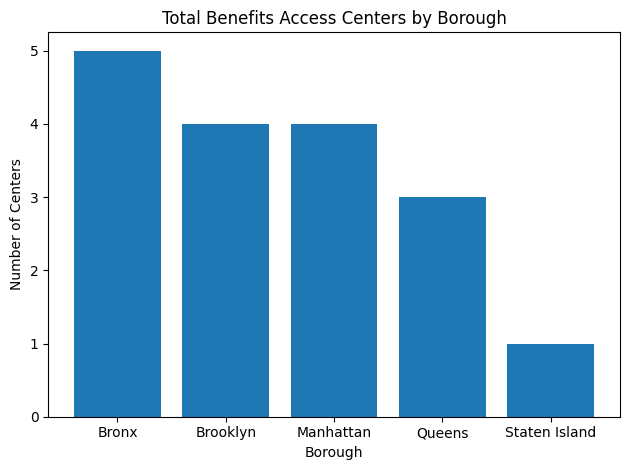

In [16]:
plt.figure()
plt.bar(borough_summary["Borough"], borough_summary["total_centers"])
plt.title("Total Benefits Access Centers by Borough")
plt.xlabel("Borough")
plt.ylabel("Number of Centers")
plt.tight_layout()
plt.show()


**Visualization 2 - Service Characteristics by Borough (Grouped Bar Chart)**

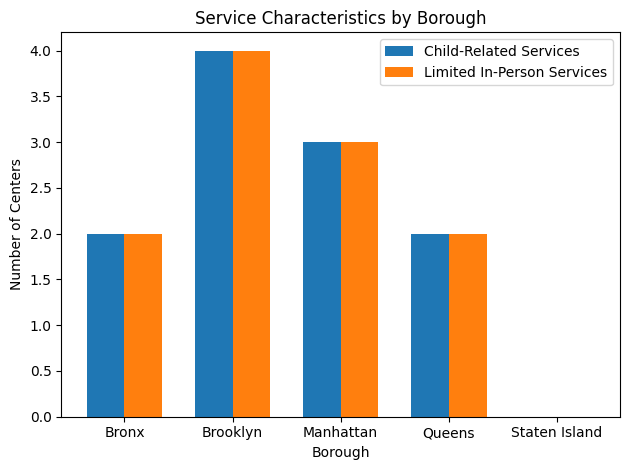

In [17]:
import numpy as np

x = np.arange(len(borough_summary["Borough"]))
width = 0.35

plt.figure()
plt.bar(x - width/2, borough_summary["child_service_centers"], width, label="Child-Related Services")
plt.bar(x + width/2, borough_summary["limited_in_person_centers"], width, label="Limited In-Person Services")

plt.xticks(x, borough_summary["Borough"])
plt.xlabel("Borough")
plt.ylabel("Number of Centers")
plt.title("Service Characteristics by Borough")
plt.legend()
plt.tight_layout()
plt.show()


The visualizations clearly illustrate borough-level differences in both the
availability and characteristics of NYC Benefits Access Centers. The first chart
shows that the Bronx has the highest number of centers overall, while Staten Island
has only one, indicating uneven geographic distribution across boroughs.

The second chart highlights differences in service characteristics. Brooklyn stands
out, as all of its centers provide child-related services and operate with limited
in-person service features. Manhattan shows a similar pattern, while the Bronx and
Queens display more mixed coverage. Staten Island lacks both service characteristics
entirely.

Together, these visualizations reinforce that service accessibility varies not only
by proximity but also by the type of services offered, adding an important layer of
insight beyond the original distance-based analysis.


---
## Step 4 - Prompt Engineering

In this step, prompt engineering is used to demonstrate how structured prompts
can guide automated analysis and summarization of data-driven results. Rather
than directly querying a language model, this step focuses on designing clear,
well-scoped prompts that could be used to generate insights from the project’s
findings.


In [18]:
def build_analysis_prompt(summary_table):
    prompt = f"""
You are an urban data analyst reviewing a study on NYC Benefits Access Centers
and CUNY campuses.

Context:
- The table below summarizes access center characteristics by borough.
- Columns include total centers, child-related services, and limited in-person services.

Task:
1. Identify which boroughs appear best served.
2. Identify any boroughs that appear underserved.
3. Describe any notable patterns or inequalities.

Data:
{summary_table.to_string(index=False)}

Instructions:
- Base your answer only on the data provided.
- Do not speculate beyond the table.
- Keep the response concise and analytical.
"""
    return prompt

analysis_prompt = build_analysis_prompt(borough_summary)
print(analysis_prompt)



You are an urban data analyst reviewing a study on NYC Benefits Access Centers
and CUNY campuses.

Context:
- The table below summarizes access center characteristics by borough.
- Columns include total centers, child-related services, and limited in-person services.

Task:
1. Identify which boroughs appear best served.
2. Identify any boroughs that appear underserved.
3. Describe any notable patterns or inequalities.

Data:
      Borough  total_centers  child_service_centers  limited_in_person_centers  pct_child_services  pct_limited_in_person
        Bronx              5                      2                          2                40.0                   40.0
     Brooklyn              4                      4                          4               100.0                  100.0
    Manhattan              4                      3                          3                75.0                   75.0
       Queens              3                      2                          2    

# Final Thoughts
##Project Extension Overview

This extended analysis built upon the original project by shifting the focus from
geographic proximity alone to deeper service-level and borough-level insights.
While the initial study examined how close NYC Benefits Access Centers are to CUNY
campuses, the second phase explored how service characteristics vary across boroughs
and how those differences may impact accessibility.


##Methods Applied and Rationale

Regular expressions were used to transform unstructured text from access center
descriptions into structured analytical features, such as the presence of
child-related services and limited in-person service operations. These features
allowed the analysis to move beyond location data and examine how centers function
operationally.

Pivot tables were then applied to aggregate these features at the borough level,
enabling direct comparisons across NYC. Visualization further strengthened this
analysis by making borough-level patterns and disparities easier to identify and
interpret.


##Questions Addressed by the New Analysis

This phase of the project answered several questions that were not addressed in the
original analysis, including:
- Which boroughs have higher concentrations of child-related services
- Where limited in-person service models are most common
- How service characteristics differ even when access centers are geographically present

The results showed that boroughs such as Brooklyn and Manhattan consistently offer
these service features, while other boroughs display more varied or limited coverage.


##Methodological Decisions

API-based data retrieval was proposed in the slides however it was determined to be not useful. The datasets used are relatively stable, and API access would not have
added significant analytical value. In contrast, regular expressions and
visualization directly enabled new insights by extracting meaning from unstructured
text and presenting results in an interpretable format.


##Prompt Engineering Component

Prompt engineering was included to demonstrate how structured prompts can guide
automated interpretation of analytical results. Although no language model was
executed, this step illustrates how context, constraints, and task definition can
be designed to ensure that any generated analysis remains grounded in the data.


##Overall Conclusion

Overall, this second phase enhanced the project by applying new data management
techniques to answer more nuanced questions about service accessibility. The
analysis demonstrates how thoughtful methodological choices can extend the value
of an existing project while remaining aligned with real-world data constraints.
